In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [18]:
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [19]:
edges = edges.merge(risks[['from', 'to', 'index']], left_on=['from', 'to'], right_on=['from', 'to'], how='left')
edges.head()

,from,to,l,h,time,timeU,timeUCB,border,index
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0,40.518729
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0,34.595838
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0,29.757905
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0,32.325426
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0,21.123829


In [20]:
nodes.head()

,Agglomeration_ID,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
0,2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
1,5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
2,7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
3,4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4,4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


In [21]:
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB', 'index'])

In [22]:
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

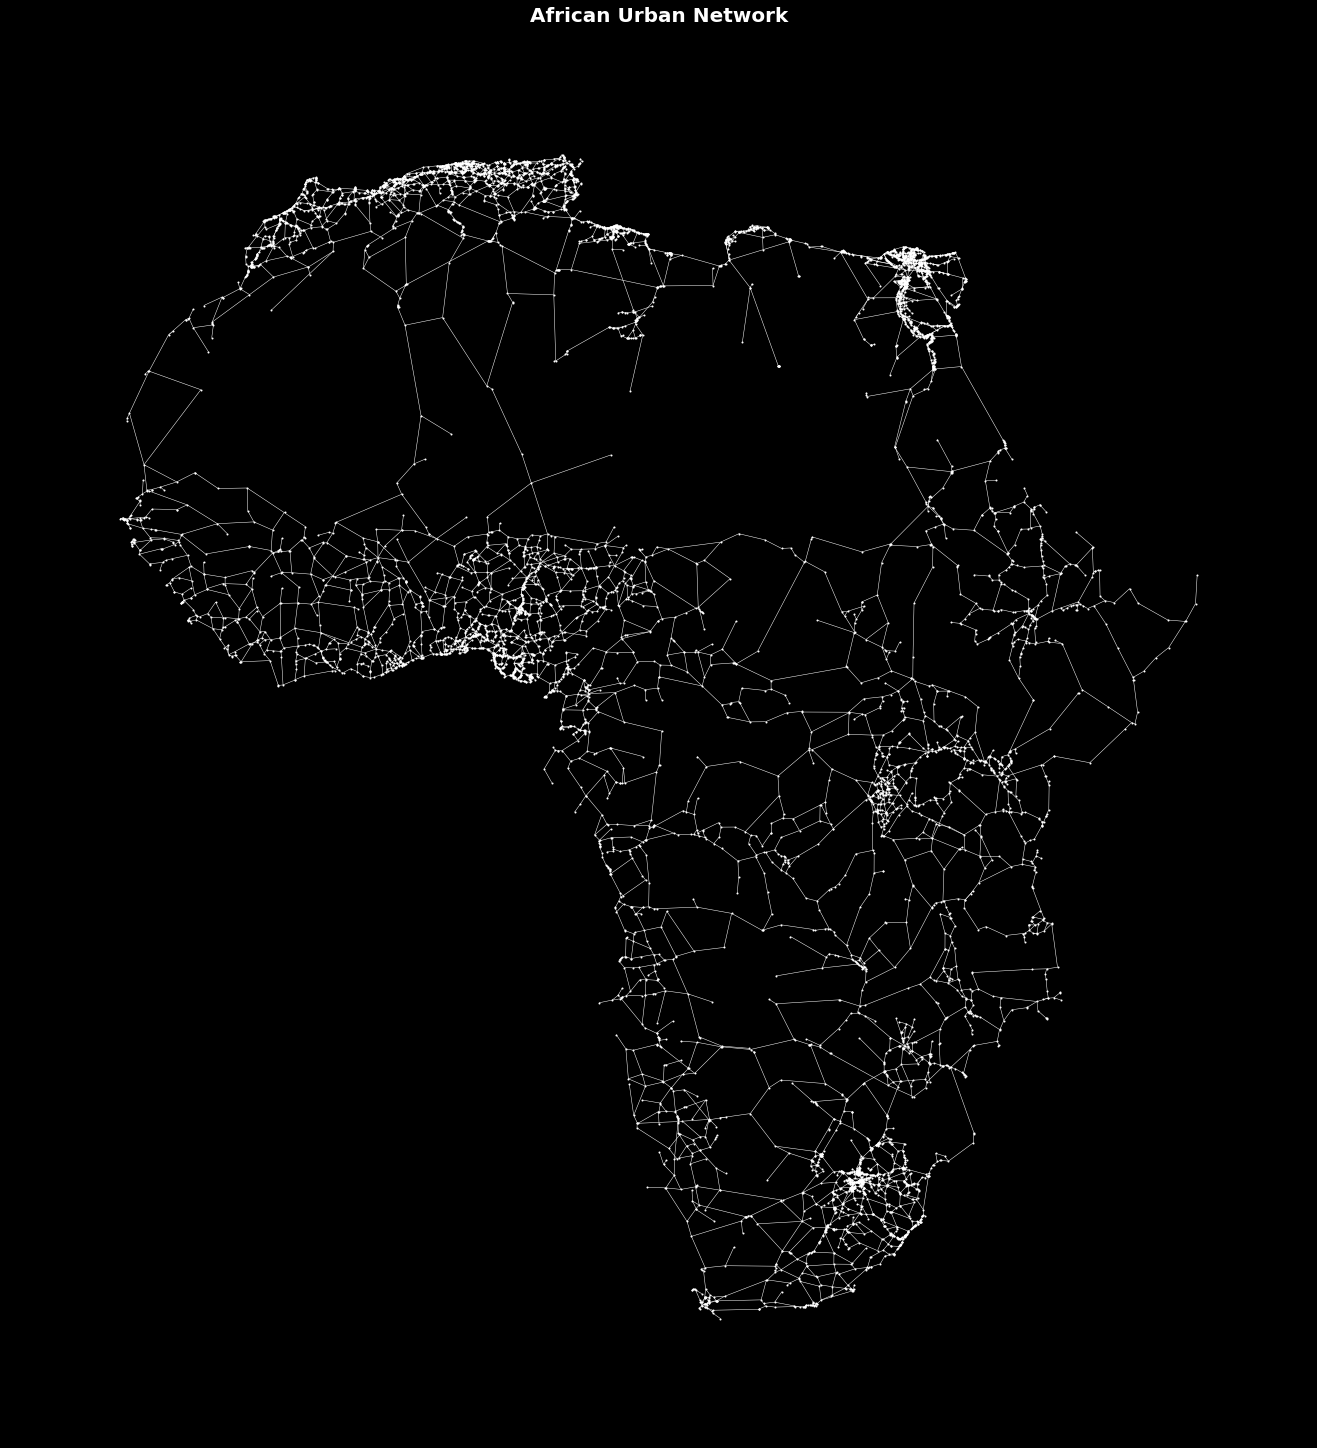

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

position = dict(zip(list(G.nodes()), [[v['x'], v['y']] for k, v in G.nodes(data=True)]))

nx.draw_networkx_edges(G, ax=ax, pos=position, edge_color='w', width=0.5)
nx.draw_networkx_nodes(G, ax=ax, pos=position, node_color='w', node_size=1)

ax.set_facecolor('k')

fig.suptitle('African Urban Network', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-test.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [25]:
tween = nx.edge_betweenness_centrality(G)

In [57]:
tween = pd.DataFrame([[i[0], i[1], tween.get(i)] for i in tween.keys()], columns=['from', 'to', 'tween'])

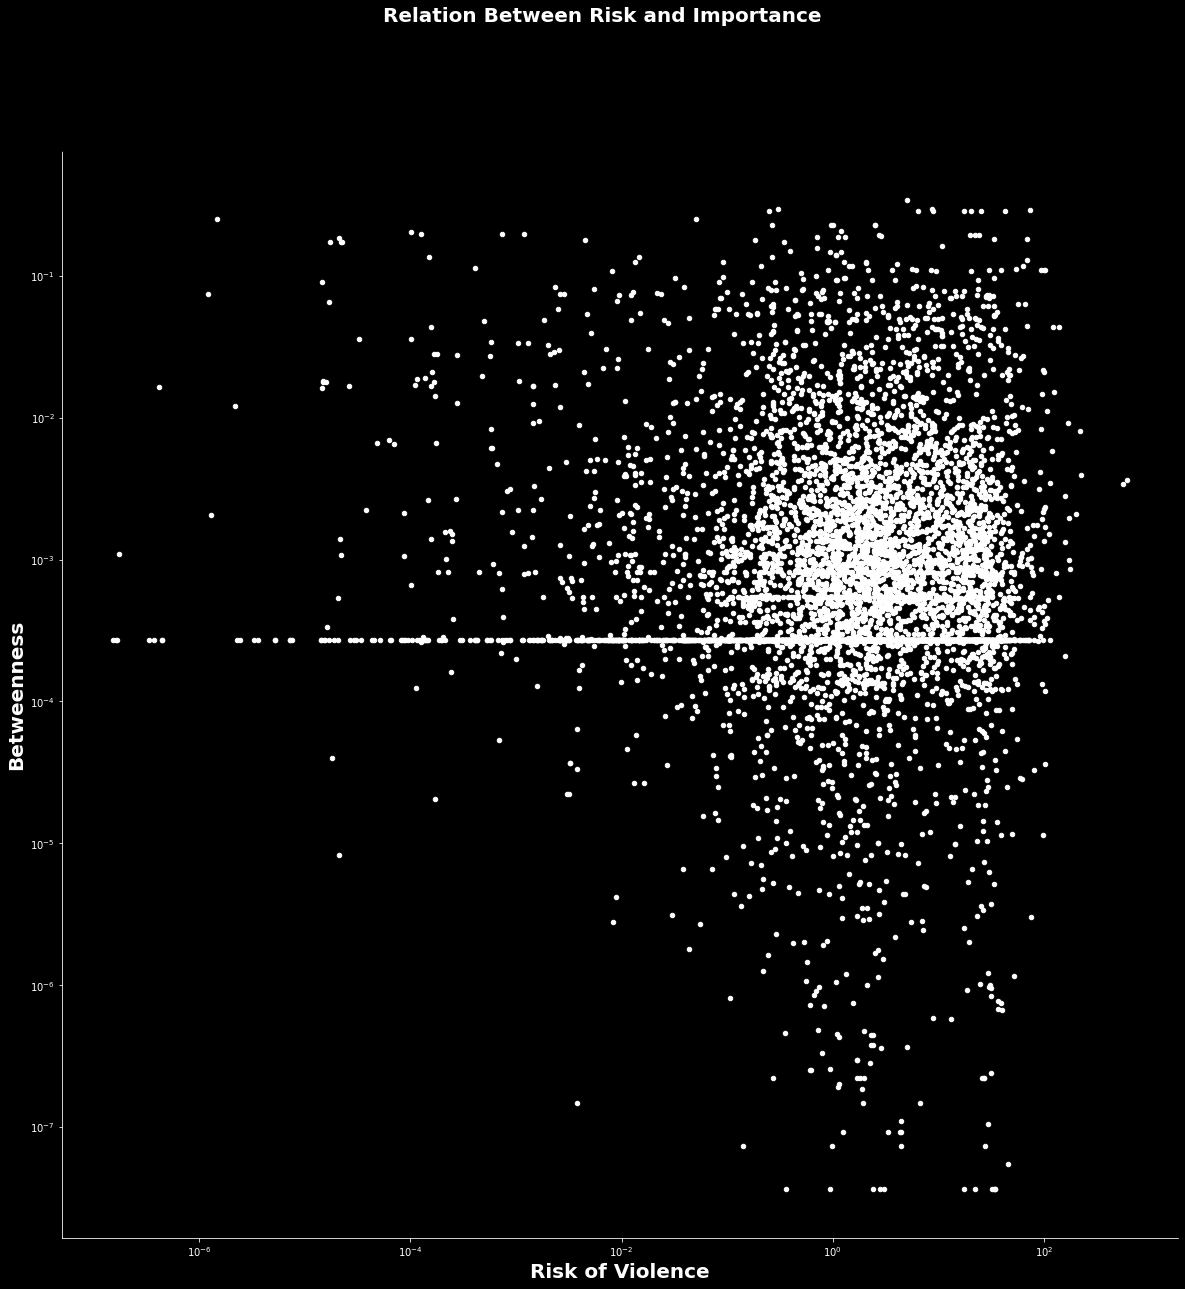

In [74]:
joined = edges.merge(tween, left_on=['from', 'to'], right_on=['from', 'to'], how='left')

fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')

joined.plot('index', 'tween', color='w', kind='scatter', ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("Risk of Violence", color="w", fontdict=font)
ax.set_ylabel("Betweenness", color="w", fontdict=font)

fig.suptitle('Relation Between Risk and Importance', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvtween.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [116]:
joined = joined.merge(nodes[['Agglomeration_ID', 'Region']].rename(columns={'Agglomeration_ID': 'from'}), left_on='from', right_on='from').rename(columns={'Region': 'from_region'})
joined = joined.merge(nodes[['Agglomeration_ID', 'Region']].rename(columns={'Agglomeration_ID': 'to'}), left_on='to', right_on='to').rename(columns={'Region': 'to_region'})
joined.head()

,from,to,l,h,time,timeU,timeUCB,border,index,tween,from_region,to_region
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0,40.518729,2.568469e-03,South,South
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0,34.595838,2.716284e-04,South,South
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0,29.757905,2.716284e-04,South,South
3,1000559,1000567,3.735195,motorway,2.241117,2.241117,2.241117,0,34.386273,3.691606e-08,South,South
4,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0,32.325426,2.716284e-04,South,South


In [117]:
joined['crossing'] = joined['from_region'] != joined['to_region']

In [118]:
region = []

for row in joined.iterrows():
    if row[1]['crossing']: 
        region = np.append(region, "crossing")
    else: 
        region = np.append(region, row[1]['from_region'])

In [ ]:
joined['region'] = region

In [119]:
from colorcet import palette
from matplotlib import colors
pal = np.tile(palette['glasbey_light'], len(nodes) // len(palette['glasbey_light']))
pal = colors.ListedColormap(pal)

In [129]:
crosswalk = pd.DataFrame({'region': np.unique(region),
                          'color': np.random.choice(palette['glasbey_light'], len(np.unique(region)))})

joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')

In [183]:
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

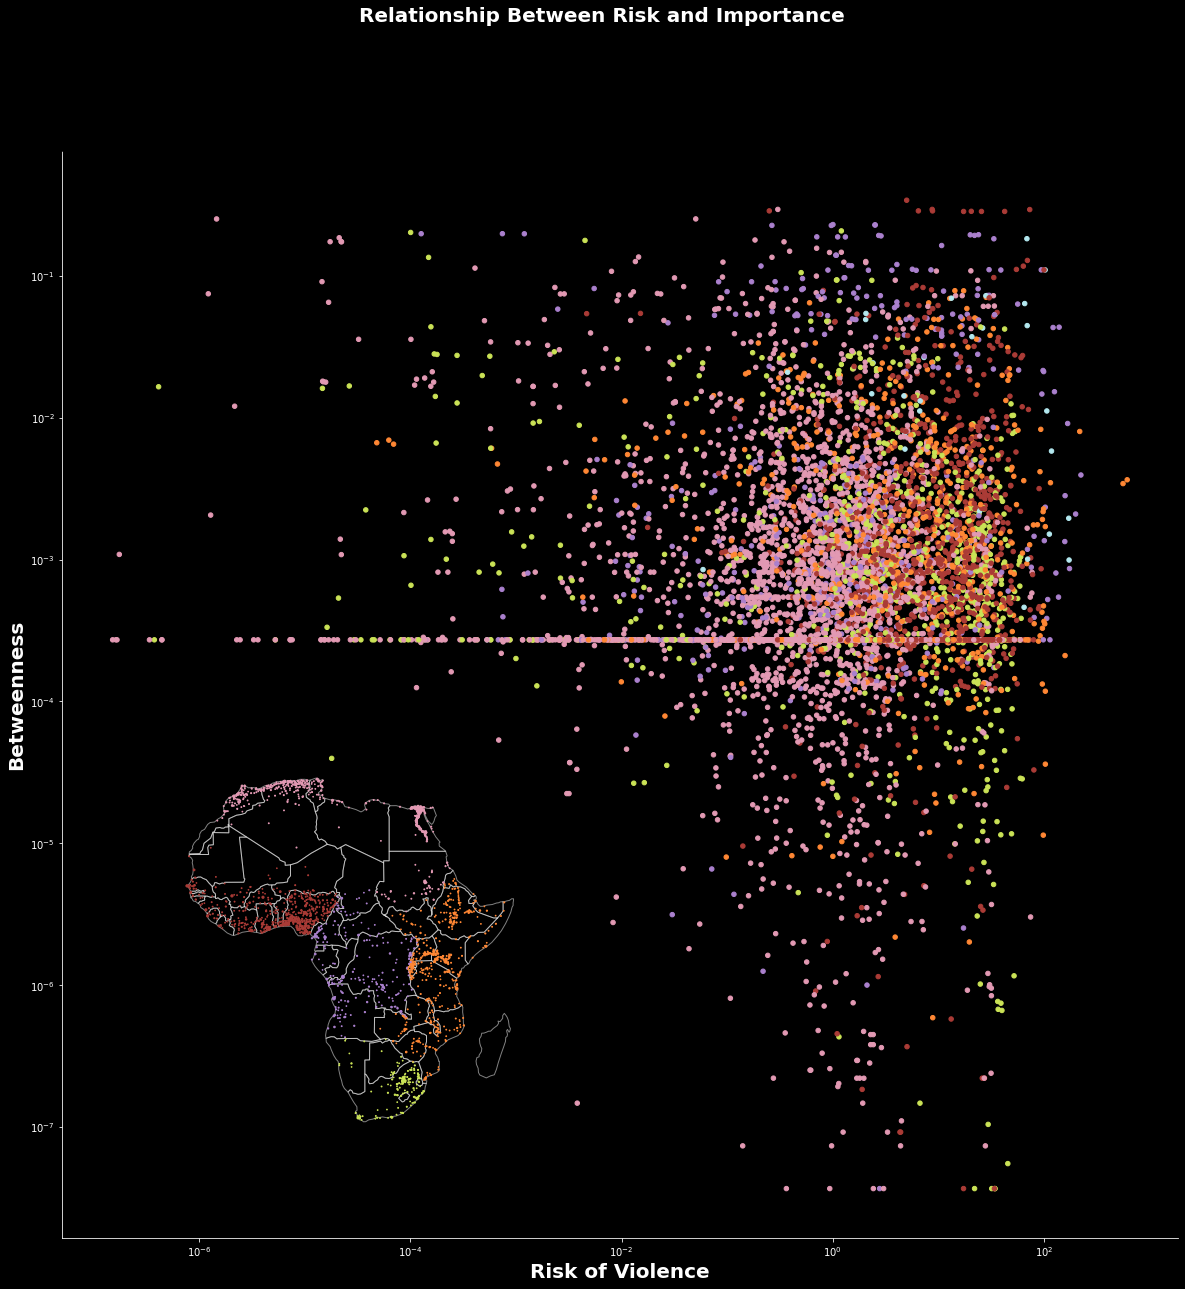

In [215]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')

joined.plot('index', 'tween', color=joined['color'], kind='scatter', ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("Risk of Violence", color="w", fontdict=font)
ax.set_ylabel("Betweenness", color="w", fontdict=font)

sub = plt.axes([0.2, 0.05] + [0.25, 0.55], facecolor='#000000')
africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)

legend = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
legend = legend.merge(crosswalk, left_on='Region', right_on='region', how='left')
legend.head()

import math
legend['markersize'] = np.sqrt(legend['Pop2015'] / 100000)

legend.plot(color=legend['color'], markersize='markersize', ax=sub)

fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvtween.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [217]:
edges.l.max()

856.875461182392

In [192]:
edges['risk'] = edges['index']

In [203]:
lengths = []
components = list()

for i in np.arange(10, edges.risk.max()):
    G_ = G.copy()
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['index'] > i]
    
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)
    
components = pd.concat(components)
components.head()

,component,threshold,gcc
1343488,0,10.0,5513
1,0,10.0,5513
1081349,0,10.0,5513
10,0,10.0,5513
11,0,10.0,5513


In [204]:
def clean_components(dataframe, nodes=nodes, edges=edges):
    edges_copy = edges.copy()
    nodes_copy = nodes.copy()

    components_copy = dataframe[dataframe.threshold.isin(np.arange(10, 1250, 30))].merge(nodes_copy,
                                                                                         left_index=True, right_on='Agglomeration_ID', how='left')


    components_copy['aggnm'] = components_copy['agglosName']
    components_copy['pop15'] = components_copy['Pop2015']
    components_copy['thrno'] = components_copy['threshold']
    components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

    components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]

    biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
    biggest['biggest_rank'] = biggest.pop15.rank(ascending=False, method='dense')
    n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
    n_comps.columns = [''.join(x) for x in n_comps.columns]
    
    components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                            left_on=['thrid', 'comid'], 
                                            right_on=['thrid', 'comid'], 
                                            how='left').merge(n_comps, 
                                                              left_on=['thrid', 'comid'], 
                                                              right_on=['thrid', 'comid'], 
                                                              how='left').sort_values('pop15count', ascending=False)
    
    return components_copy

In [205]:
components = clean_components(components)

In [206]:
trends = components[['thrno', 'gcc']].groupby('thrno', as_index=False).first()
trends['lag'] = trends.gcc.shift(1)
trends['change'] =  trends.gcc - trends.lag
changepoints = np.append([10], np.append(trends.nlargest(6, 'change').sort_values('thrno').thrno.to_numpy(), 1240))

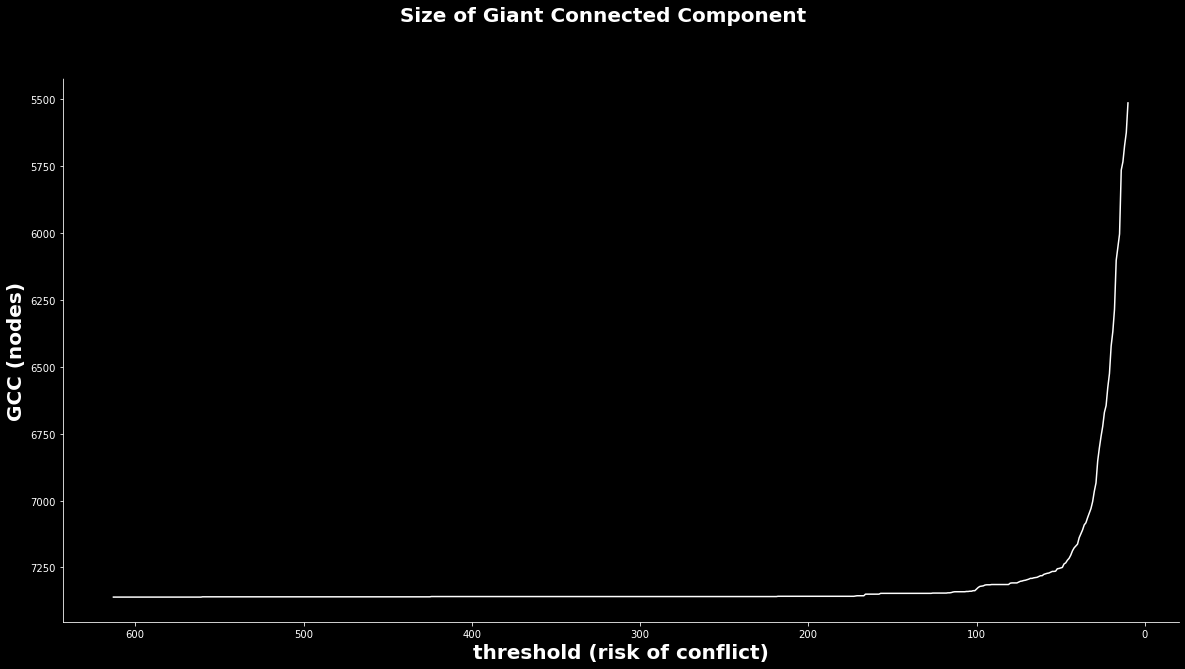

In [212]:
size = [0.25, 0.55]

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')

ax.plot(np.arange(10, edges.risk.max()), lengths, color='w')

ax.invert_xaxis()
ax.invert_yaxis()

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("threshold (risk of conflict)", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)

fig.suptitle('Size of Giant Connected Component', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-gcc-risk.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [214]:
%time nx.average_shortest_path_length(G)

CPU times: user 52.5 s, sys: 246 ms, total: 52.7 s
Wall time: 53 s


55.86020422703673

In [ ]:
# 